In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import brier_score_loss

In [2]:
Db = pd.read_csv('Bank_Personal_Loan_Modelling.csv',index_col=[0])

In [3]:
Db.shape # There are 5000 observations / rows and 14 attributes / columns.

(5000, 13)

In [4]:
Db.info() # Data type of each variable; number of values in each variable

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 5000
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIP Code            5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal Loan       5000 non-null   int64  
 9   Securities Account  5000 non-null   int64  
 10  CD Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 546.9 KB


##### The dataset provides customer information of a bank. 
This is a personalised marketing problem with a risk modelling element. 
The classification goal is to predict if a customer with liabilities with the bank (mortgage, credit card expenses)
 will avail(1 / 0) a personal loan.
 

In [5]:
Db.sample(10)

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
ID,,,,,,,,,,,,,
2654,30,5,121,94555,2,3.1,1,408,0,0,0,1,0
470,48,23,10,94609,2,0.7,3,0,0,0,0,1,1
3439,43,17,72,94806,1,2.8,1,271,0,0,0,1,0
1732,43,19,125,92122,3,2.4,1,0,1,0,0,1,0
888,41,16,118,94720,2,3.3,1,0,0,0,0,1,0
1870,55,30,44,94025,2,2.0,2,0,0,0,0,1,0
3849,57,32,84,93106,4,1.3,3,0,0,0,0,0,1
3364,58,34,54,93003,4,1.3,2,0,0,0,0,1,0
1053,43,17,49,95812,3,2.2,2,103,0,0,0,1,1


In [6]:
dupes = Db.duplicated() # No duplicates
sum(dupes)

0

In [7]:
Db.isnull().values.any() # No missing values

False

In [8]:
Db.sort_values(by=['Experience'])[Db.sort_values(by=['Experience']).Experience<0] 

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
ID,,,,,,,,,,,,,


In [9]:
Db.head()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
ID,,,,,,,,,,,,,
1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


A number of years of experience are indicated as negative values, possibly due to human error. This was actually realised by an examination of the .csv file and sorting out the values in each column in ascending order for a preliminary analysis.
These values are being changed to positive values to maintain data inegrity

In [10]:
Db.loc[Db.Experience==-1,'Experience']=1
Db.loc[Db.Experience==-2,'Experience']=2
Db.loc[Db.Experience==-3,'Experience']=3


In [11]:
Db.sort_values(by=['Experience'])[Db.sort_values(by=['Experience']).Experience<0]  

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
ID,,,,,,,,,,,,,


# Understanding each attribute


1. ID - Customer ID (numeric 1 to 5000).  There is no correlation between customer ID and the chances of a customer availing a personal loan.

2. Age - Customer's age in completed years (numeric)

3. Experience - Years of Professional Experience (numeric)

4. Income - Annual Income of the Customer in thousands of dollars (numeric)

5. Zip Code - Zip Code of a customer's home address (categorical - Unique five digit number for each area - one entry had only a four digit identifier - possibly human error. Corrected as other columns appeared accurate)

6. Family - Family size of the customer (numeric)

7. CCAvg - Average spending on credit cards per month in thousands of dollars (numeric)

8. Education - Education Level (categorical - 1 -"Undergrad', 2 - "Graduate", 3 - "Advanced / Professional")

9. Mortgage - Value of house mortgage, if any in thousands of dollars (numeric)

10. Personal Loan - Target Variable - Personal loan availed - Yes (1) / No (0) (categorical)

11. Securities Account - Does the customer have a securities account with the bank - Yes (1) / No (0) (categorical)

12. CD Account - Does the customer have a Certificate of Deposit (Fixed Deposit, in India) with the bank - Yes (1) / No (0) (categorical)

13. Online - Does the customer use Internet Banking facilities - Yes (1) / No (0) (categorical)

14. CreditCard - Does the customer have a Universal Bank credit card - Yes (1) / No (0) (categorical)

In [12]:
Db[['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage', 'Personal Loan']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,5000.0,45.338400,11.463166,23.0,35.0,45.0,55.0,67.0
Experience,5000.0,20.134600,11.415189,0.0,10.0,20.0,30.0,43.0
Income,5000.0,73.774200,46.033729,8.0,39.0,64.0,98.0,224.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.7,1.5,2.5,10.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.0,0.0,101.0,635.0
Personal Loan,5000.0,0.096000,0.294621,0.0,0.0,0.0,0.0,1.0


# Data Distribution in Each Attribute

## Attribute - Age 

The bank has 5000 customers with ages ranging between 23 years and 67 years.  The mean customer age is 45 years.

According to "gopaysense.com", banks prefer giving loans to people in the age group of 30-50 years as they are considered financially stable. People in this age group have worked for a few years and still have several years left to repay the personal loan easily. People who are above 60 years age may find it challenging to repay personal loans.

https://www.gopaysense.com/blog/important-factors-personal-loan-applications/


#### How many customers fall within the age bracket 30 to 50 years?
#### How many of those customers have availed personal loans?
#### How is the attribute 'age' distributed? Is it skewed?
#### Is there any correlation between age of the customer and chances of availing a personal loan?

In [13]:
Db.loc[(Db['Age'] >= 30)&(Db['Age'] <=50)]['Age']

ID
2       45
3       39
4       35
5       35
6       37
        ..
4988    48
4989    34
4993    30
4994    45
4997    30
Name: Age, Length: 2642, dtype: int64

The bank has 2642 customers in the target age bracket, which is healthy at 53%

In [14]:
Db.loc[(Db['Age'] >= 30) & (Db['Age'] <=50) & (Db['Personal Loan'] == 1)][['Age','Personal Loan']]

,Age,Personal Loan
ID,,
10,34,1
17,38,1
19,46,1
30,38,1
39,42,1
...,...,...
4866,50,1
4877,44,1
4884,38,1


As only 257 customers in the target age bracket have availed personal loans, there is adequate scope for the bank to market customised loans to 2385 customers without personal loans.

<AxesSubplot:xlabel='Age', ylabel='Density'>

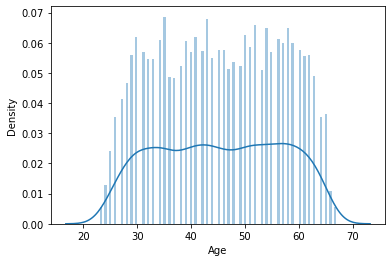

In [15]:
sns.distplot(Db['Age'],bins=100)

## Analysis 1 - LOANS AND AGE

To study the correlation between age and personal loans, it can be hypothesised that younger people are more likely to avail personal loans than older people:H1

Younger people spend more and have greater risk taking capacity.  Older people are more likely to be conservative in spending and their needs are lesser. Hence, it can be hypothesised that they are less likely to take personal loans.

The null hypothesis that needs to be rejected in this case is that older and younger age groups are both equally likely to avail personal loans if the oppurtunity arises :H0

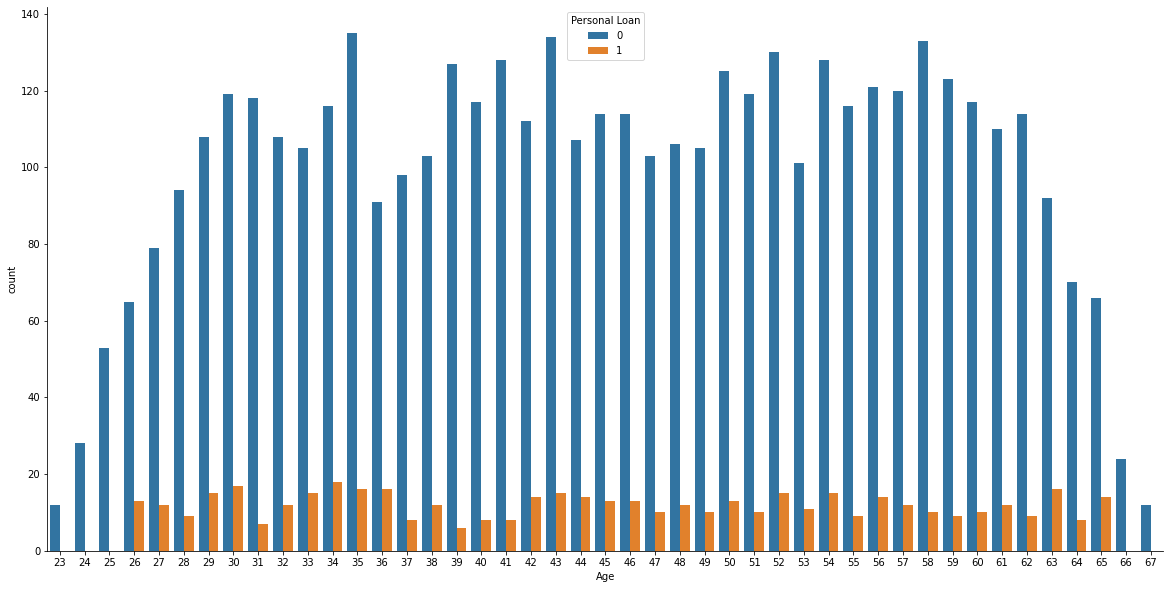

In [17]:
plt.figure(figsize=(20,10))
sns.countplot(x ='Age', hue = 'Personal Loan', data = Db)
sns.despine()

It can be observed that between the ages of 25 and 65 years, individuals in every age group have availed personal loans in similar numbers in most age bands. The data does not indicate that the null hypothesis can be rejected. Applicants whether young or old avail the oppurtunities to take personal loans, in this dataset. So given other attributes while it may be true that the age group 30 to 50 years is preferred for loan disbursement, for this dataset the bank must market personal loans to all age groups, in future.

# Analysis 2 - Professional Experience and Age

A critical factor that banks consider is an experience. For, e.g., a person with 15 years of experience will be given preference over some who are just starting out or has only 2-3 years of experience. Banks also prefer borrowers who have been serving in the same industry for a few years while considering the loan application. In case a person has a record of shifting professions rapidly, then a bank may not approve their loan easily.

https://www.gopaysense.com/blog/important-factors-personal-loan-applications/

The mean experience of the customers in the bank is 20 years.  Customers range from no professional experience to 43 years of experience.

It can be hypothesised that younger customers will have lower professional experience and older customers will have a higher professional experience.:H0

Age and professional experience have no relation to each other:H1

#### Is there any correlation between age of customers and their professional experience?
#### How is data related to professional experience distributed? Is it skewed?




<b>Personal loans have been availed by customers with no professional experience to very significant professional experience.</b>

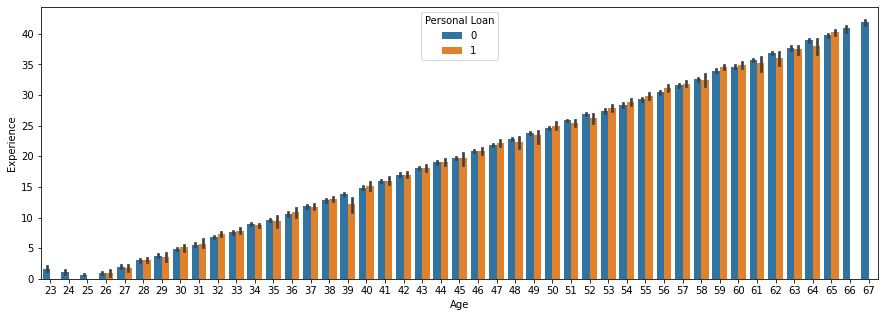

In [19]:
plt.figure(figsize=(15,5))
sns.barplot(data=Db,x='Age',y='Experience',hue='Personal Loan')
plt.show()

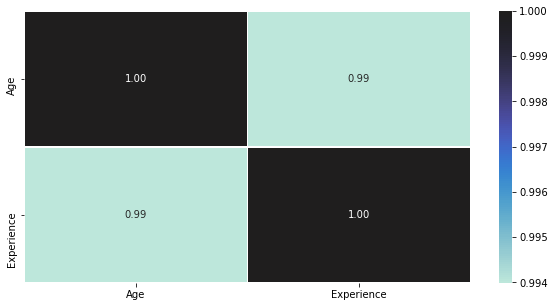

In [20]:
plt.figure(figsize=(10,5))
sns.heatmap(Db[['Age','Experience']].corr(), annot=True, linewidths=.5, fmt= '.2f', center = 1 )  
plt.show()

The <b>strong positive correlation between age and professional experience (0.99) is clearly established.</b> The null hypothesis has not been rejected. Hence, further analysis of professional experience as a factor for loans is not needed. <b>This attribute can be dropped.</b> By considering age as a factor for deciding loan eligibility, aspects related to professional experience are accounted for in this dataset.

# Analysis 3 - Income, CCAvg and Personal Loan

<b> To gain a better understanding of the relation between income and CCAvg, we can plot a correlation plot</b>

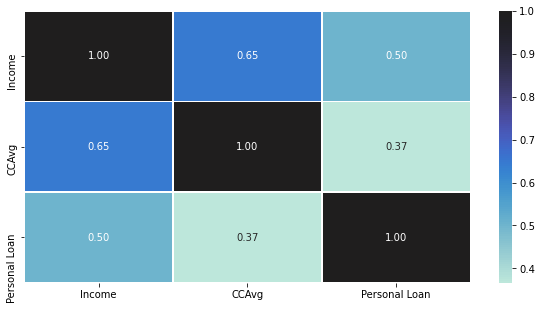

In [21]:
plt.figure(figsize=(10,5))
sns.heatmap(Db[['Income','CCAvg','Personal Loan']].corr(), annot=True, linewidths=.5, fmt= '.2f', center = 1 )  
plt.show()

We see that there is a good postive correlation between Income and CCAvg (0.65) and both Income and CCAvg are postively correlated to the Personal Loan Column as well

It can be hypothesised that lower income group customers are more likely to avail personal loans and higher income group customers are less likely to avail personal loans: H0. The data skew indicates that this hypothesis stands a chance of rejection.

Alternately, as loans are a function of financial need for various reasons, it is possible that customers in all income groups need and avail personal loans depending on circumstances: H1

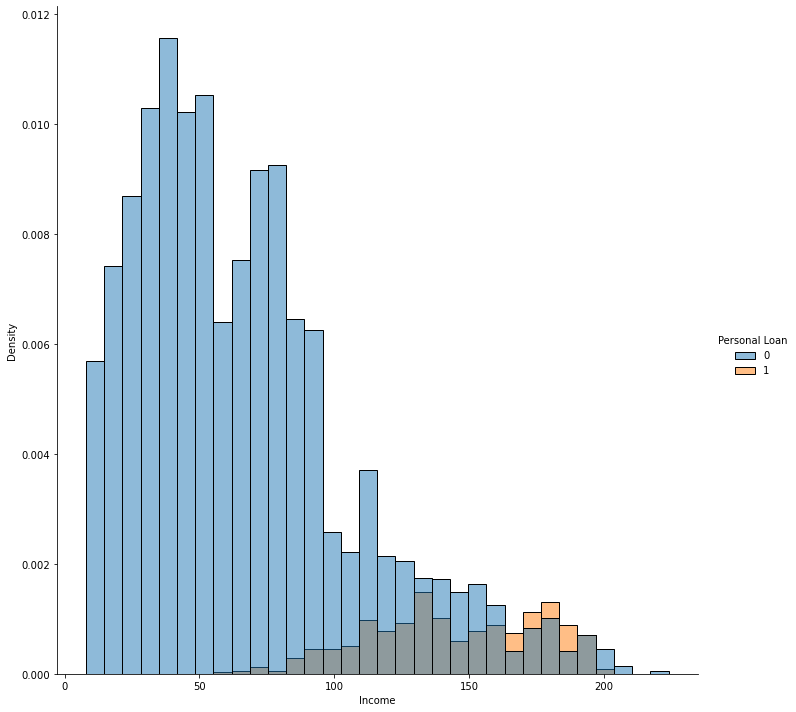

In [22]:
sns.displot(Db, x="Income", hue="Personal Loan", stat='density',height=10)

The figure clearly indicates that in this dataset, higher income group customers well above the median values of the dataset have availed more personal loans than lower income groups.

Our null hypothesis can be rejected in this dataset. In this dataset, the alternate hypothesis that higher income group customers are more likely to avail personal loans than lower income group customers is validated.



There is scope for the bank to <b>offer customised personal loans to customers whose income falls around the median value of customer incomes tending to the higher income group</b>. They are keen to avail loans and there are significant customers yet to avail loans. They are a viable target group.

Any new customer in the high income group should be offered a personal loan as it appears that there is a culture for such customers to take loans in this society due to various reasons.

It is interesting that a <b>very large group of customers in the low to medium income group are not availing personal loans.</b> Perhaps, the bank is very conservative in loan disbursement. <b>The bank could devise schemes offering low value personal loans to low income group customers with attractive discounts, offers etc.</b> However, the risk of giving loans to lower income groups needs further study and deliberation based on social factors, culture etc.

# Analysis 4 - Credit Card Popularity, Average Spending and Personal Loan

#### How many customers have Credit Cards? 

It can be hypothesised that higher income groups spend more on their credit cards and lower income groups spend lesser on their cards. H0 

It can also be hypothesised that higher the personal loan that is availed by a customer, higher the credit card spending H0

In [23]:
Db.loc[Db.CreditCard==1,'CreditCard'].sum()

1470

<b> 1470 out of 5000 customers have a credit card</b>

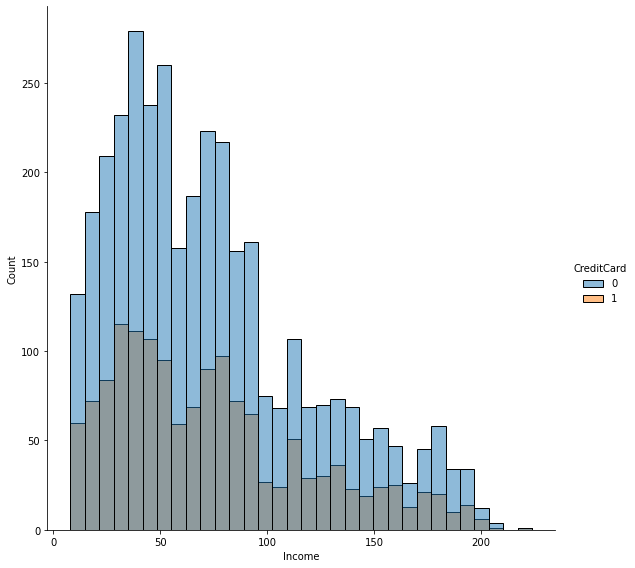

In [137]:
sns.displot(x ='Income', hue = 'CreditCard', data = Db,height=8)
sns.despine()

In [25]:
pd.crosstab(Db['CreditCard'],Db['Personal Loan'])

Personal Loan,0,1
CreditCard,,
0,3193,337
1,1327,143


Out of 5000 customers, only 1470 have credit cards (nearly 29%). Credit card penetration is relatively low.  However, credit cards as a device are popular across all income groups. <b>There is no direct correlation between the customers who have / own credit cards and their preference to avail loans.</b> 

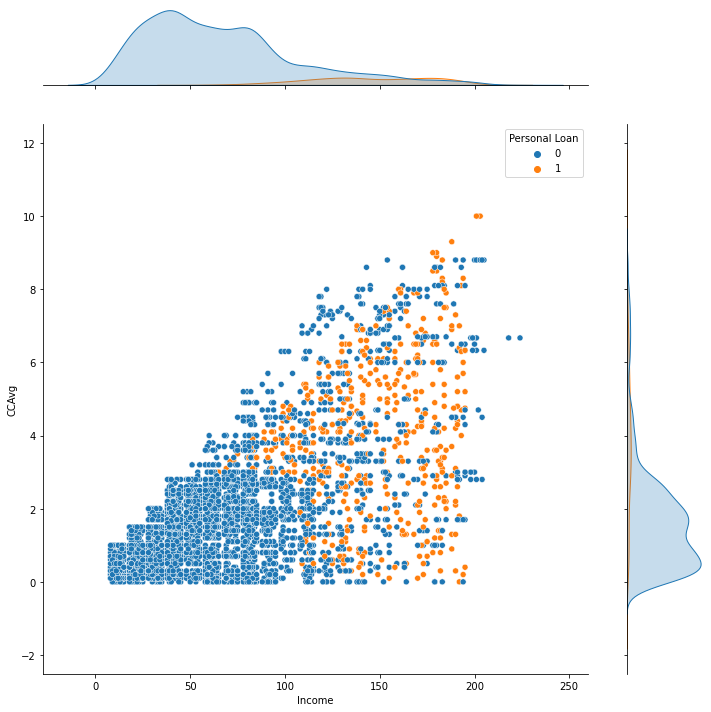

In [27]:
sns.jointplot(data=Db, x="Income", y="CCAvg", hue='Personal Loan',space=0.5,height=10)

It is thus established that higher income customers with credit cards spend more on their cards. They are also more likely to take personal loans.  Customers who spend around 3000$ to 3400$ have a higher chance of availing personal loans. <b> Therefore, high income group customers with credit card expenditures around the median without personal loans could be given customised offers with a greater assurance of success. </b>

# Analysis 5 - Mortgage, Income and Personal Loan

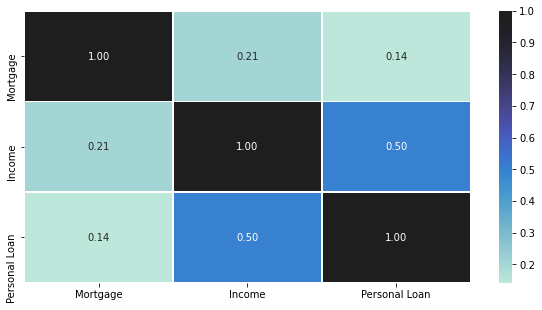

In [28]:
plt.figure(figsize=(10,5))
sns.heatmap(Db[['Mortgage','Income','Personal Loan']].corr(), annot=True, linewidths=.5, fmt= '.2f', center = 1 )  
plt.show()

Mortgages are slightly positively correlated to income and personal loans.

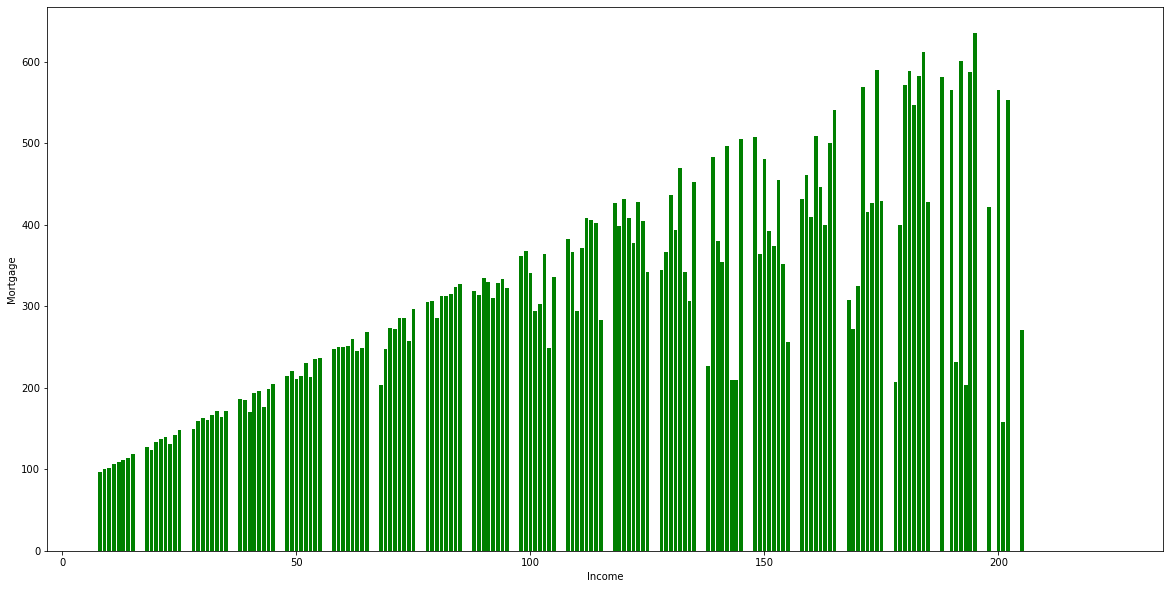

In [29]:
plt.figure(figsize=(20,10))
plt.bar(Db['Income'], Db['Mortgage'], color='green') 
plt.xlabel("Income") 
plt.ylabel("Mortgage") 
plt.show() 

In [30]:
Db.loc[(Db['Mortgage']==0)].groupby('Personal Loan').count()['Mortgage']


Personal Loan
0    3150
1     312
Name: Mortgage, dtype: int64

In [31]:
Db.loc[(Db['Mortgage']>0)].groupby('Personal Loan').count()['Mortgage']


Personal Loan
0    1370
1     168
Name: Mortgage, dtype: int64

It is clear that in most cases, as the customer's income increases, the ability to take larger mortgages increases. However,<b> 63% of the customers have no mortgage or personal loan. Only 3% customers have both mortgages and personal loans. </b>No useful conclusions can be drawn from this analysis. The presence of outliers is noted.

# Removing Outliers in Mortgage

In [43]:
from scipy import stats
z=np.abs(stats.zscore(Db.Mortgage))
threshold=3
print(np.where(z>3))

(array([  42,   59,  119,  288,  303,  327,  338,  354,  365,  459,  473,
        479,  528,  570,  679,  684,  782,  888,  952, 1023, 1111, 1162,
       1167, 1273, 1277, 1288, 1303, 1304, 1328, 1359, 1372, 1623, 1674,
       1716, 1736, 1783, 1789, 1875, 1889, 1937, 1970, 2027, 2041, 2076,
       2217, 2319, 2382, 2394, 2422, 2443, 2541, 2590, 2653, 2668, 2687,
       2714, 2753, 2768, 2769, 2776, 2812, 2841, 2934, 2942, 2946, 2956,
       2989, 3012, 3020, 3021, 3065, 3209, 3304, 3357, 3373, 3411, 3467,
       3470, 3472, 3515, 3571, 3608, 3612, 3620, 3662, 3702, 3776, 3875,
       3884, 3919, 3945, 4016, 4238, 4240, 4294, 4345, 4422, 4541, 4585,
       4655, 4672, 4698, 4812, 4842, 4859], dtype=int64),)


In [44]:
Db1=Db[(z< 3)] # Removing the outliers using Z Score method.

In [45]:
Db1.shape # 105 outlier entries have been removed from the original dataabase of 5000 entries (< 5%)

(4895, 13)

# Analysis 6 - Family and Education

The attribute <b>'family' does not have any significant direct correlation with other attributes.</b>  However, it can be hypothesised that,
larger families are more likely to avail personal loans to meet requirements such as higher education. H0

Alternately, if more family members are earning, the requirement of personal loans is not significant. H1

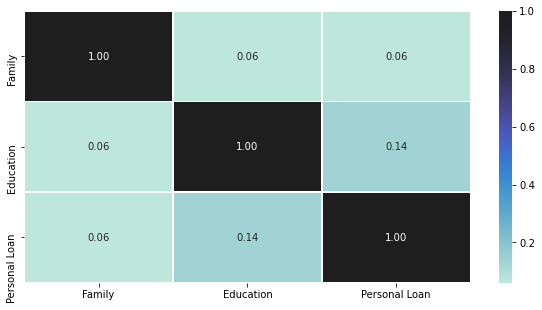

In [32]:
plt.figure(figsize=(10,5))
sns.heatmap(Db[['Family','Education','Personal Loan']].corr(), annot=True, linewidths=.5, fmt= '.2f', center = 1 )  
plt.show()

<AxesSubplot:xlabel='Family', ylabel='count'>

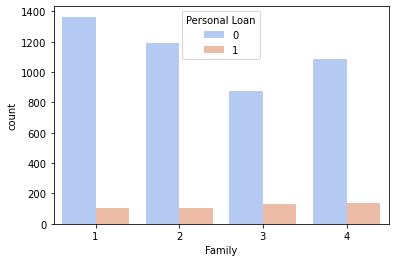

In [33]:
sns.countplot(x='Family',data=Db,hue='Personal Loan',palette='coolwarm')

In this dataset, it appears that larger families do take more loans but the <b>differences in each category are not significant.</b> So, the rejection of the null hypothesis is inconclusive.

<AxesSubplot:xlabel='Education', ylabel='count'>

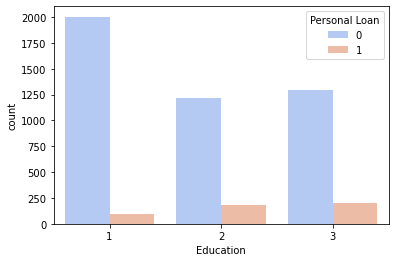

In [34]:
sns.countplot(x='Education',data=Db,hue='Personal Loan',palette='coolwarm')

In [35]:
Db.loc[(Db['Education']==1)].groupby('Personal Loan').count()['Education']

Personal Loan
0    2003
1      93
Name: Education, dtype: int64

In [36]:
Db.loc[(Db['Education']==2)].groupby('Personal Loan').count()['Education']

Personal Loan
0    1221
1     182
Name: Education, dtype: int64

In [37]:
Db.loc[(Db['Education']==3)].groupby('Personal Loan').count()['Education']

Personal Loan
0    1296
1     205
Name: Education, dtype: int64

<b>Customers who are more educated do take more loans. Customers who are at undergrad level are less likely to take personal loans.</b> Thus, the bank can study its customer dataset and <b>offer more loans to customers with higher education without loans.</b>

In [46]:
Db1.kurt()

Age                   -1.152227
Experience            -1.143849
Income                 0.108628
ZIP Code              -1.094377
Family                -1.410363
CCAvg                  2.848349
Education             -1.548795
Mortgage               1.795811
Personal Loan          6.409662
Securities Account     4.701843
CD Account            12.433209
Online                -1.845808
CreditCard            -1.189732
dtype: float64

In [47]:
Db1.drop('ZIP Code',axis=1,inplace=True) #ZIP code are just series of numbers with no analytical value.
Db1.drop('Experience',axis=1,inplace=True) # from Analysis 2
Db1.drop('Family',axis=1,inplace=True) # From Analysis 6

In [48]:
Db1.sample(10)

,Age,Income,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
ID,,,,,,,,,,
4100,61,60,2.8,2,0,0,0,0,1,1
3098,58,44,2.2,3,0,0,0,0,0,0
4074,51,19,0.2,1,0,0,0,0,0,0
2887,50,58,1.3,2,0,0,0,0,1,0
4377,40,71,3.0,1,272,0,0,0,1,0
1412,65,184,5.4,3,176,1,0,1,1,1
2874,48,35,0.1,1,0,0,1,0,1,0
3505,46,15,0.6,3,0,0,1,0,1,0
271,60,63,2.2,1,0,0,0,0,1,0


In [49]:
Db1.isnull().values.any() # Just a crosscheck!

False

In [50]:
n_true = len(Db1.loc[Db1['Personal Loan'] == True])
n_false = len(Db1.loc[Db1['Personal Loan'] == False])
print("Number of customers with personal loans: {0} ({1:2.2f}%)".format(n_true, (n_true / (n_true + n_false)) * 100 ))
print("Number of customers without personal loans: {0} ({1:2.2f}%)".format(n_false, (n_false / (n_true + n_false)) * 100))

Number of customers with personal loans: 433 (8.85%)
Number of customers without personal loans: 4462 (91.15%)


# Splitting the data

In [51]:
from sklearn.model_selection import train_test_split

X = Db1.drop('Personal Loan',axis=1)     
Y = Db1['Personal Loan']   

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)
# 1 - random seed number

x_train.head()

,Age,Income,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
ID,,,,,,,,,
3403,64,95,0.0,3,0,0,0,1,1
4689,29,69,1.8,2,0,0,0,1,1
4506,40,90,1.1,2,0,1,0,1,0
2239,48,35,1.4,3,0,0,0,1,0
4,35,100,2.7,2,0,0,0,0,0


In [52]:
print("{0:0.2f}% Data in training set".format((len(x_train)/len(Db1.index)) * 100)) # Check the data split.
print("{0:0.2f}% Data in test set".format((len(x_test)/len(Db1.index)) * 100))

69.99% Data in training set
30.01% Data in test set


In [53]:
print("Original Personal Loan Availed   : {0} ({1:0.2f}%)".format(len(Db1.loc[Db1['Personal Loan'] == 1]), (len(Db1.loc[Db1['Personal Loan'] == 1])/len(Db1.index)) * 100))
print("Original Personal Loan Not Availed   : {0} ({1:0.2f}%)".format(len(Db1.loc[Db1['Personal Loan'] == 0]), (len(Db1.loc[Db1['Personal Loan'] == 0])/len(Db1.index)) * 100))
print("")
print("Training Personal Loan Availed    : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train)) * 100))
print("Training Personal Loan Not Availed   : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train)) * 100))
print("")
print("Test Personal Loan Availed        : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test)) * 100))
print("Test Personal Loan Not Availed      : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test)) * 100))
print("")

Original Personal Loan Availed   : 433 (8.85%)
Original Personal Loan Not Availed   : 4462 (91.15%)

Training Personal Loan Availed    : 305 (8.90%)
Training Personal Loan Not Availed   : 3121 (91.10%)

Test Personal Loan Availed        : 128 (8.71%)
Test Personal Loan Not Availed      : 1341 (91.29%)



## Normalizing the Data using Z-score

In [54]:
xtrainsc = x_train.apply(zscore)
xtestsc = x_test.apply(zscore)

# Logistic Regression

In [55]:
model = LogisticRegression(max_iter=100000000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=100000000)

In [56]:
pred_train = model.predict(x_train)
train_accuracy=accuracy_score(y_train, pred_train)
print('Train Accuracy: ',np.round(train_accuracy,5))

Train Accuracy:  0.95271


In [57]:
y_pred = model.predict(x_test)
test_accuracy=accuracy_score(y_test, y_pred)
print('Test Accuracy: ',np.round(test_accuracy,5))

Test Accuracy:  0.94963


In [58]:
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.95873   0.98732   0.97281      1341
           1    0.80682   0.55469   0.65741       128

    accuracy                        0.94963      1469
   macro avg    0.88277   0.77101   0.81511      1469
weighted avg    0.94549   0.94963   0.94533      1469



Text(0.5, 42.0, 'Predicted label')

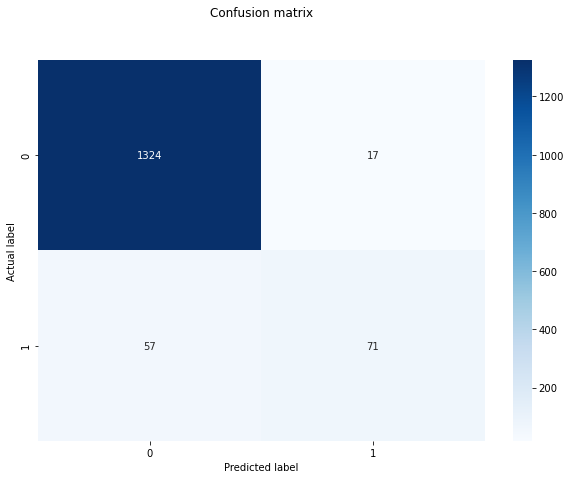

In [59]:
conf_mat = confusion_matrix(y_test, y_pred)
Db1_conf_mat = pd.DataFrame(conf_mat)
plt.figure(figsize = (10,7))
sns.heatmap(Db1_conf_mat, annot=True,cmap='Blues', fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

The confusion matrix

True Positives (TP): 75 customers took loans as predicted.

True Negatives (TN): 1325 customers didn't take loans as predicted.

False Negatives (FN): ("Type II error") 53 customers were predicted to not avail loans, but they did take loans. In this case, this error needs to be reduced.

False Positives (FP): ("Type I error") 16 customers were predicted to avail loans, but they did not take loans.

In [60]:
xtrainsc = x_train.apply(zscore)
xtestsc = x_test.apply(zscore)
model1 = LogisticRegression()
model1.fit(xtrainsc, y_train)
model1.score(xtrainsc, y_train)
print('Train Accuracy: ',np.round(train_accuracy,5))

Train Accuracy:  0.95271


In [61]:
ypred = model1.predict(xtestsc)
model1.score(xtestsc, y_test)
print('Test Accuracy: ',np.round(test_accuracy,5))

Test Accuracy:  0.94963


<AxesSubplot:>

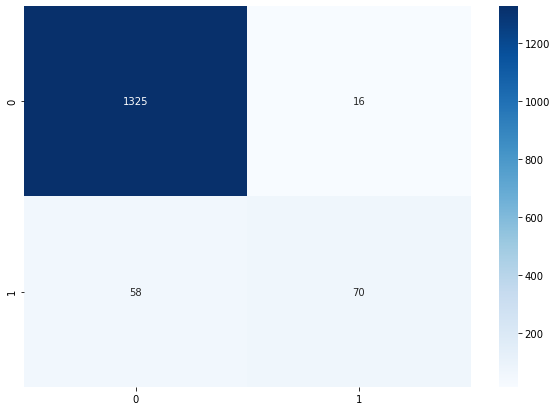

In [62]:
conf_mat = confusion_matrix(y_test, ypred)
Db1_conf_mat = pd.DataFrame(conf_mat)
plt.figure(figsize = (10,7))
sns.heatmap(Db1_conf_mat, annot=True,cmap='Blues', fmt='g')

In [63]:
print(classification_report(y_test, ypred, digits=5))

              precision    recall  f1-score   support

           0    0.95806   0.98807   0.97283      1341
           1    0.81395   0.54688   0.65421       128

    accuracy                        0.94963      1469
   macro avg    0.88601   0.76747   0.81352      1469
weighted avg    0.94551   0.94963   0.94507      1469



In [64]:
TP = 77
TN = 1324
FP = 17
FN = 51

In [65]:
print((TP + TN) / float(TP + TN + FP + FN)) # Classification Accuracy - After Standardisation vs Before Standardisation
print(metrics.accuracy_score(y_test, y_pred))

0.953710006807352
0.9496255956432947


In [66]:
print((FP + FN) / float(TP + TN + FP + FN)) # Misclassification Rate - After Standardisation vs Before Standardisation
print(1 - metrics.accuracy_score(y_test, y_pred))

0.04628999319264806
0.05037440435670526


In [67]:
print(TP / float(TP + FN)) # Sensitivity - After Standardisation vs Before Standardisation
print(metrics.recall_score(y_test, y_pred))

0.6015625
0.5546875


In [68]:
print(TN / float(TN + FP)) # Specificity

0.9873228933631618


In [69]:
print(TP / float(TP + FP)) # Precision - After Standardisation vs Before Standardisation
print(metrics.precision_score(y_test, y_pred))

0.8191489361702128
0.8068181818181818


In [70]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from numpy import sqrt
from numpy import argmax

Best Threshold=0.061330, G-Mean=0.878


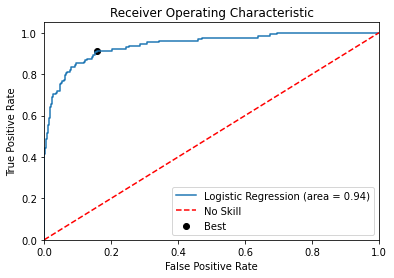

In [71]:
logit_roc_auc = roc_auc_score(y_test, model1.predict_proba(xtestsc)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, model1.predict_proba(xtestsc)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--',label='No Skill')
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Model1_ROC')
plt.show()

Best Threshold=0.329733, F-Score=0.709


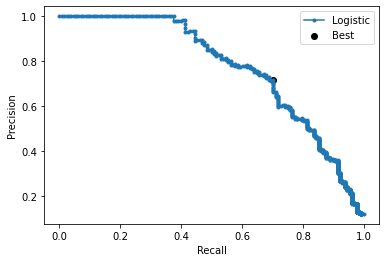

In [72]:
from sklearn.metrics import precision_recall_curve  # Precision Recall Curve
yhat=model1.predict_proba(xtestsc)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, yhat)
fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Naive Bayes

In [73]:
from sklearn.naive_bayes import GaussianNB

In [74]:
NB_model = GaussianNB()
NB_model.fit(xtrainsc, y_train.ravel())

GaussianNB()

In [75]:
NB_train_model_pred = NB_model.predict(xtrainsc)

from sklearn import metrics

print("Model Accuracy: {0:.4f}".format(metrics.accuracy_score(y_train, NB_train_model_pred)))
print()

Model Accuracy: 0.8920



In [76]:
NB_test_model_pred = NB_model.predict(xtestsc)

from sklearn import metrics

print("Model Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, NB_test_model_pred, normalize=True)))
print()

Model Accuracy: 0.8918



Confusion Matrix


<AxesSubplot:>

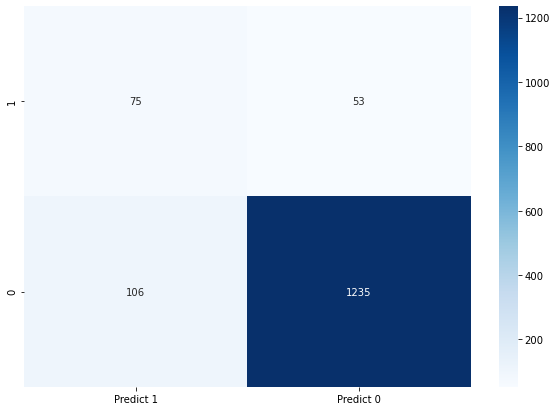

In [77]:
print("Confusion Matrix")
cm=metrics.confusion_matrix(y_test, NB_test_model_pred, labels=[1, 0])

Db1_cm = pd.DataFrame(cm,index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (10,7))
sns.heatmap(Db1_cm, annot=True,cmap='Blues', fmt='g')

In [78]:
print("Classification Report")
print(metrics.classification_report(y_test, NB_test_model_pred, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.41      0.59      0.49       128
           0       0.96      0.92      0.94      1341

    accuracy                           0.89      1469
   macro avg       0.69      0.75      0.71      1469
weighted avg       0.91      0.89      0.90      1469



Best Threshold=0.003464, G-Mean=0.879


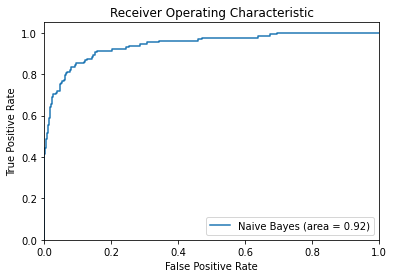

In [79]:
nb_roc_auc = roc_auc_score(y_test, NB_model.predict_proba(xtestsc)[:,1])
nb_prob = NB_model.predict_proba(xtestsc)
fpr2,tpr2,thresholds2=roc_curve(y_test,nb_prob[:,1])
gmeans = sqrt(tpr2 * (1-fpr2))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.figure()
plt.plot(fpr, tpr, label='Naive Bayes (area = %0.2f)' % nb_roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('NB_ROC')
plt.show()

Best Threshold=0.103630, F-Score=0.527


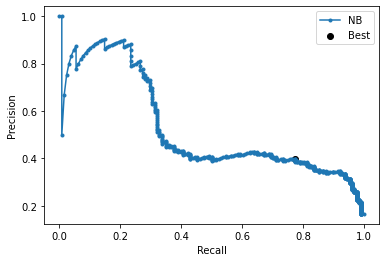

In [80]:
from sklearn.metrics import precision_recall_curve  # Precision Recall Curve
yhat=NB_model.predict_proba(xtestsc)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, yhat)
fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
plt.plot(recall, precision, marker='.', label='NB')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# kNN

In [81]:
kNN = KNeighborsClassifier(n_neighbors= 6 , weights = 'distance' )

In [82]:
kNN.fit(xtrainsc, y_train)

KNeighborsClassifier(n_neighbors=6, weights='distance')

In [83]:
kNN_train_pred = kNN.predict(xtrainsc)

from sklearn import metrics

print("Model Accuracy: {0:.4f}".format(metrics.accuracy_score(y_train, kNN_train_pred)))
print()

Model Accuracy: 1.0000



In [84]:
kNN_test_pred = kNN.predict(xtestsc)

from sklearn import metrics

print("Model Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, kNN_test_pred)))
print()

Model Accuracy: 0.9632



Confusion Matrix


<AxesSubplot:>

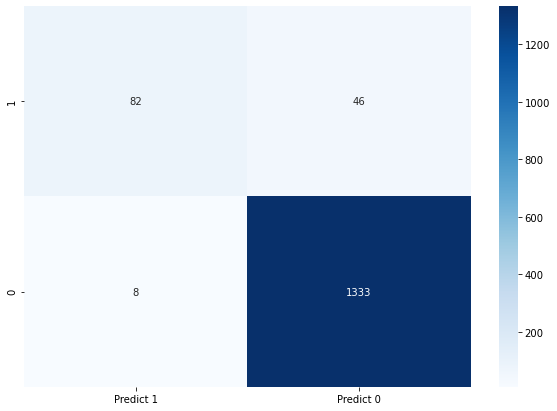

In [85]:
print("Confusion Matrix")
cm=metrics.confusion_matrix(y_test, kNN_test_pred, labels=[1, 0])

Db1_cm = pd.DataFrame(cm,index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (10,7))
sns.heatmap(Db1_cm, annot=True,cmap='Blues', fmt='g')

In [86]:
print("Classification Report")
print(metrics.classification_report(y_test, kNN_test_pred, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.91      0.64      0.75       128
           0       0.97      0.99      0.98      1341

    accuracy                           0.96      1469
   macro avg       0.94      0.82      0.87      1469
weighted avg       0.96      0.96      0.96      1469



Best Threshold=0.000976, G-Mean=0.896


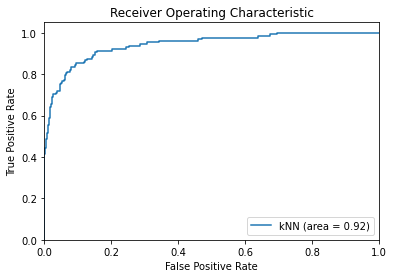

In [87]:
kNN_roc_auc = roc_auc_score(y_test, kNN.predict_proba(xtestsc)[:,1])
kNN_prob = kNN.predict_proba(xtestsc)
fpr3,tpr3,thresholds3=roc_curve(y_test,kNN_prob[:,1])
gmeans = sqrt(tpr3 * (1-fpr3))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.figure()
plt.plot(fpr, tpr, label='kNN (area = %0.2f)' % kNN_roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('kNN_ROC')
plt.show()

Best Threshold=0.330027, F-Score=0.773


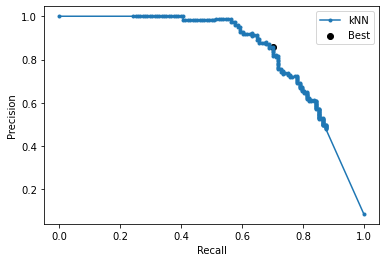

In [88]:
from sklearn.metrics import precision_recall_curve  # Precision Recall Curve
yhat=kNN.predict_proba(xtestsc)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, yhat)
fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
plt.plot(recall, precision, marker='.', label='kNN')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [89]:
scores =[]
for k in range(1,50):
    kNN = KNeighborsClassifier(n_neighbors = k, weights = 'distance' )
    kNN.fit(xtrainsc, y_train)
    scores.append(kNN.score(xtestsc, y_test))      

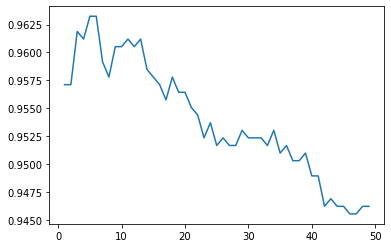

In [90]:
plt.plot(range(1,50),scores)

Maximum accuracy:- 0.9639210347174949 at K = 4


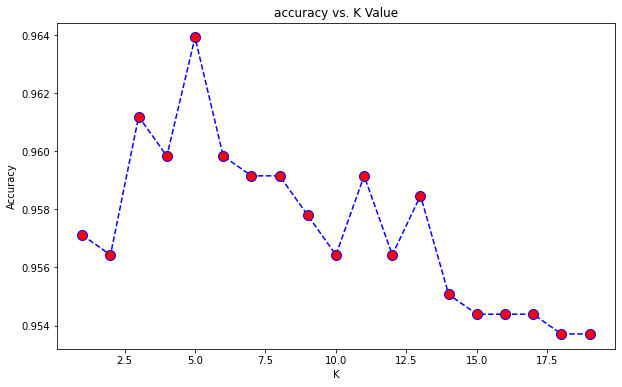

In [91]:
acc = []

from sklearn import metrics
for i in range(1,20):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(xtrainsc,y_train)
    yhat = neigh.predict(xtestsc)
    acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,20),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

Minimum error:- 0.03607896528250511 at K = 4


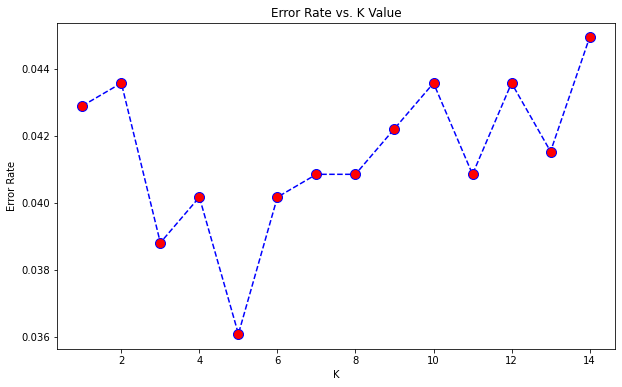

In [92]:
error_rate = []
for i in range(1,15):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(xtrainsc,y_train)
 pred_i = knn.predict(xtestsc)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,15),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))


# Decision Tree ( CART Analysis)

In [93]:
from sklearn.tree import DecisionTreeClassifier

dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1)
dTree.fit(xtrainsc, y_train)

DecisionTreeClassifier(random_state=1)

In [94]:
print(dTree.score(xtrainsc,y_train))
print(dTree.score(xtestsc,y_test))

1.0
0.953710006807352


## Visualizing the Decision Tree

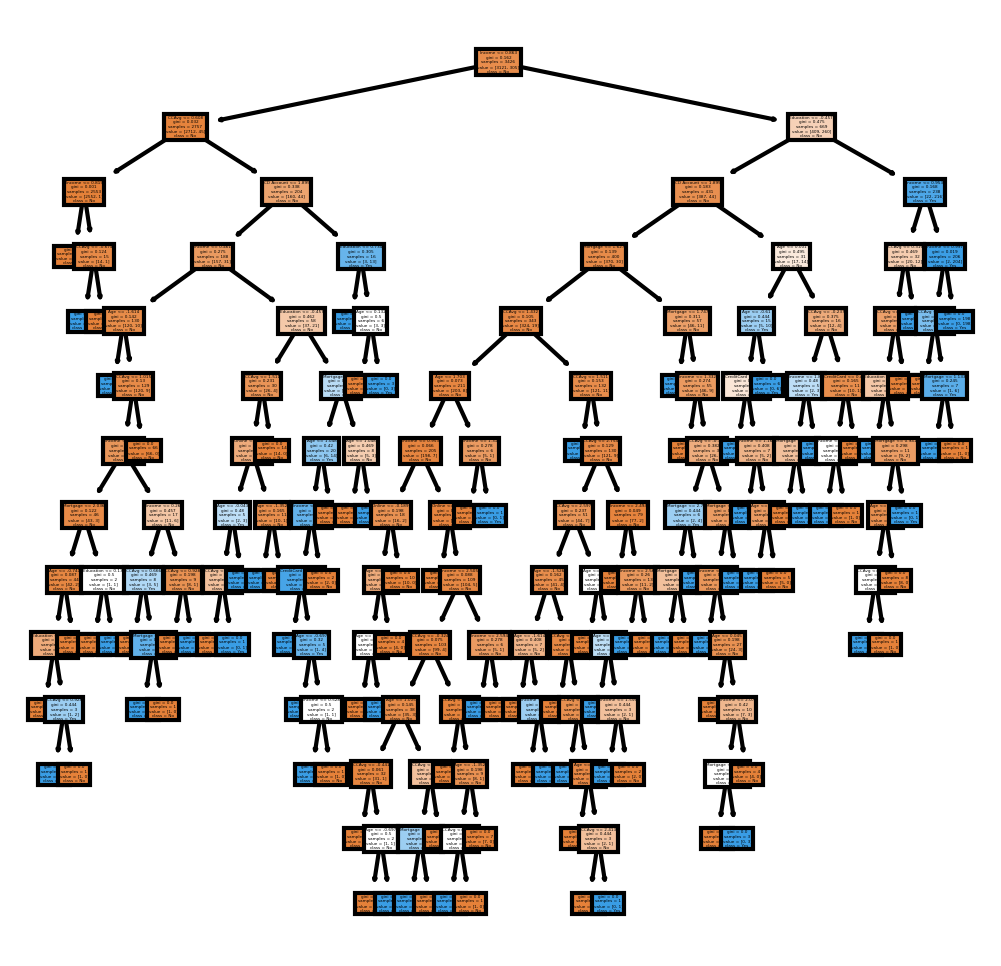

In [95]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fn = list(x_train)
cn = ['No', 'Yes']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4, 4), dpi=300)
plot_tree(dTree, feature_names = fn, class_names=cn, filled = True)

fig.savefig('tree.png')

## Reducing over fitting (Regularization)

In [96]:
dTreeR = DecisionTreeClassifier(criterion = 'gini', max_depth = 3, random_state=1)
dTreeR.fit(xtrainsc, y_train)
print(dTreeR.score(xtrainsc, y_train))
print(dTreeR.score(xtestsc, y_test))

0.9728546409807356
0.966643975493533


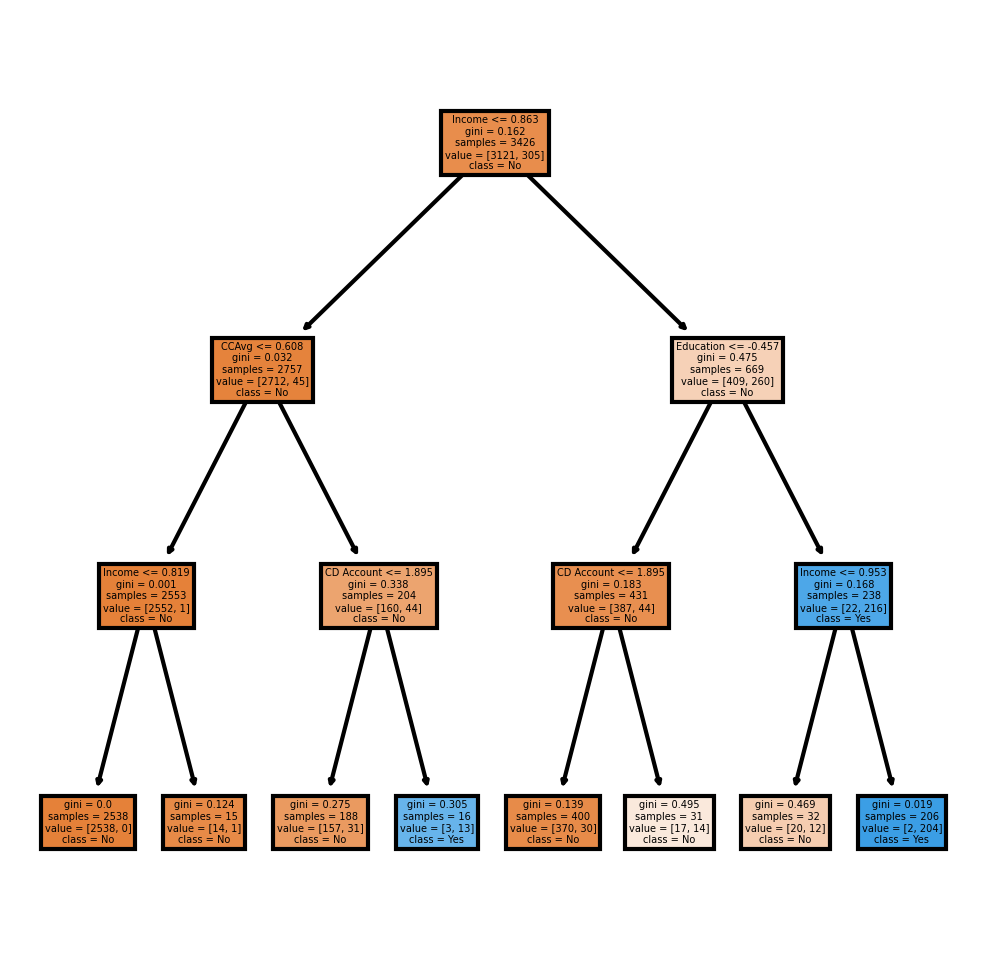

In [97]:
fn = list(x_train)
cn = ['No', 'Yes']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4, 4), dpi=300)
plot_tree(dTreeR, feature_names = fn, class_names=cn, filled = True)

fig.savefig('tree.png')

## Printing the confusion matrix

0.966643975493533


<AxesSubplot:>

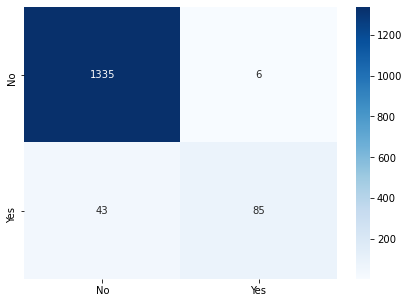

In [98]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

print(dTreeR.score(xtestsc , y_test))
y_predict = dTreeR.predict(xtestsc)

cm = confusion_matrix(y_test, y_predict, labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g',cmap='Blues')

In [99]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from numpy import sqrt
from numpy import argmax

In [100]:
ypred = dTreeR.predict(xtestsc)
print(classification_report(y_test, ypred, digits=5))


              precision    recall  f1-score   support

           0    0.96880   0.99553   0.98198      1341
           1    0.93407   0.66406   0.77626       128

    accuracy                        0.96664      1469
   macro avg    0.95143   0.82979   0.87912      1469
weighted avg    0.96577   0.96664   0.96405      1469



Best Threshold=0.164894, G-Mean=0.916


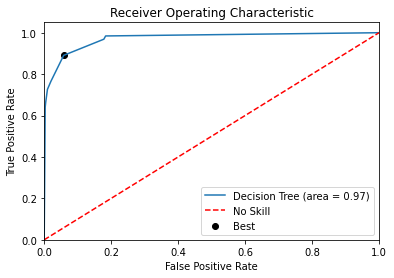

In [101]:
logit_roc_auc = roc_auc_score(y_test, dTreeR.predict_proba(xtestsc)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, dTreeR.predict_proba(xtestsc)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--',label='No Skill')
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('DecisionTree_ROC')
plt.show()

## Random Forest Classifier

In [102]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(criterion="gini",random_state=1,max_depth=4 )
clf.fit(xtrainsc,y_train)

RandomForestClassifier(max_depth=4, random_state=1)

In [103]:
print(clf.score(xtrainsc,y_train))
print(clf.score(xtestsc,y_test))

0.9740221833041448
0.966643975493533


0.966643975493533


<AxesSubplot:>

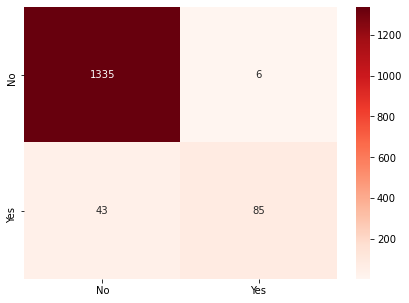

In [104]:
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(xtestsc)
print(clf.score(xtestsc, y_test))
cm=confusion_matrix(y_test, y_predict,labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g',cmap="Reds")

In [105]:
RF_test_model_pred=clf.predict(xtestsc)
print("Classification Report")
print(metrics.classification_report(y_test, RF_test_model_pred, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.93      0.66      0.78       128
           0       0.97      1.00      0.98      1341

    accuracy                           0.97      1469
   macro avg       0.95      0.83      0.88      1469
weighted avg       0.97      0.97      0.96      1469



Best Threshold=0.152448, G-Mean=0.910


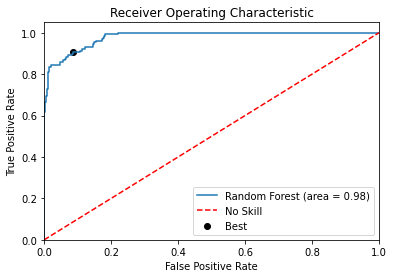

In [106]:
rf_roc_auc = roc_auc_score(y_test, clf.predict_proba(xtestsc)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(xtestsc)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--',label='No Skill')
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('DecisionTree_ROC')
plt.show()

## Bagging Classifier

In [107]:
from sklearn.ensemble import BaggingClassifier


bgcl = BaggingClassifier(base_estimator=dTree,n_estimators=70,random_state=1,max_features=3)

bgcl = bgcl.fit(xtrainsc, y_train)

In [108]:
print(bgcl.score(xtrainsc,y_train))
print(bgcl.score(xtestsc,y_test))

0.9384121424401635
0.921715452688904


0.921715452688904


<AxesSubplot:>

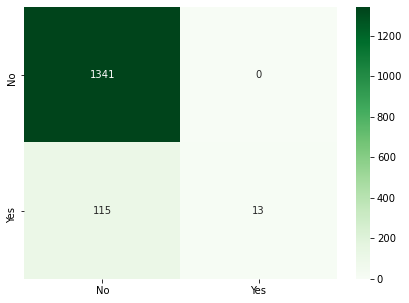

In [109]:
from sklearn.metrics import confusion_matrix
y_predict = bgcl.predict(xtestsc)
print(bgcl.score(xtestsc, y_test))
cm=confusion_matrix(y_test, y_predict,labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g',cmap="Greens")

Best Threshold=0.156605, G-Mean=0.868


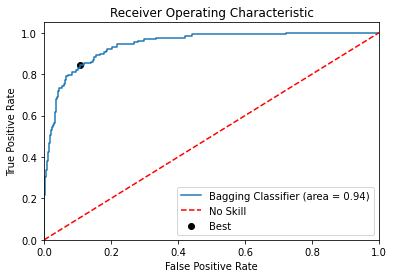

In [110]:
bagging_roc_auc = roc_auc_score(y_test, bgcl.predict_proba(xtestsc)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, bgcl.predict_proba(xtestsc)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Bagging Classifier (area = %0.2f)' % bagging_roc_auc)
plt.plot([0, 1], [0, 1],'r--',label='No Skill')
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Bagging_ROC')
plt.show()

## AdaBoosting Classifier

In [111]:
from sklearn.ensemble import AdaBoostClassifier
abcl=AdaBoostClassifier(n_estimators=50,random_state=1)
abcl.fit(xtrainsc,y_train)
print(abcl.score(xtrainsc,y_train))
print(abcl.score(xtestsc,y_test))

0.9705195563339171
0.9598366235534377


0.9598366235534377


<AxesSubplot:>

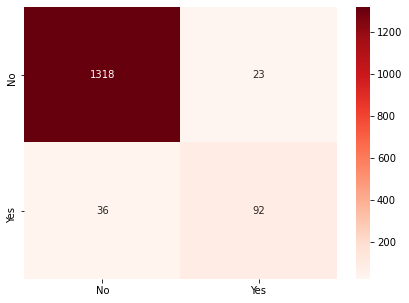

In [112]:
from sklearn.metrics import confusion_matrix
y_predict = abcl.predict(xtestsc)
print(abcl.score(xtestsc, y_test))
cm=confusion_matrix(y_test, y_predict,labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g',cmap="Reds")

In [113]:
Ada_test_model_pred=abcl.predict(xtestsc)
print("Classification Report")
print(metrics.classification_report(y_test, Ada_test_model_pred, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.80      0.72      0.76       128
           0       0.97      0.98      0.98      1341

    accuracy                           0.96      1469
   macro avg       0.89      0.85      0.87      1469
weighted avg       0.96      0.96      0.96      1469



Best Threshold=0.494768, G-Mean=0.910


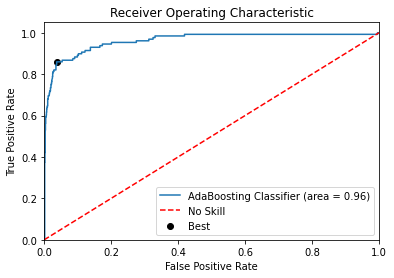

In [114]:
adaboosting_roc_auc = roc_auc_score(y_test, abcl.predict_proba(xtestsc)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, abcl.predict_proba(xtestsc)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AdaBoosting Classifier (area = %0.2f)' % adaboosting_roc_auc)
plt.plot([0, 1], [0, 1],'r--',label='No Skill')
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('AdaBoosting_ROC')
plt.show()

## Gradient Boosting Classifier

In [115]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50,random_state=1)
gbcl.fit(xtrainsc, y_train)
print(gbcl.score(xtrainsc,y_train))
print(gbcl.score(xtestsc,y_test))

0.9810274372446001
0.9714091218515998


0.9714091218515998


<AxesSubplot:>

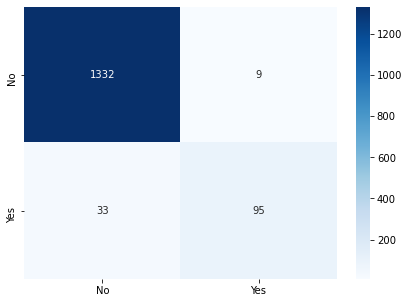

In [116]:
from sklearn.metrics import confusion_matrix
y_pred=gbcl.predict(xtestsc)
print(gbcl.score(xtestsc,y_test))
cm=confusion_matrix(y_test,y_pred,labels=[0,1])
df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g',cmap="Blues")

In [117]:
Gradient_test_model_pred=gbcl.predict(xtestsc)
print("Classification Report")
print(metrics.classification_report(y_test, Gradient_test_model_pred, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.91      0.74      0.82       128
           0       0.98      0.99      0.98      1341

    accuracy                           0.97      1469
   macro avg       0.94      0.87      0.90      1469
weighted avg       0.97      0.97      0.97      1469



Best Threshold=0.113609, G-Mean=0.913


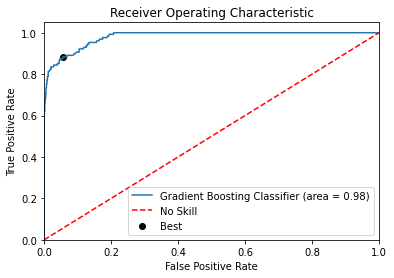

In [118]:
gradientboosting_roc_auc = roc_auc_score(y_test, gbcl.predict_proba(xtestsc)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, gbcl.predict_proba(xtestsc)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gradient Boosting Classifier (area = %0.2f)' % gradientboosting_roc_auc)
plt.plot([0, 1], [0, 1],'r--',label='No Skill')
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('GradientBoosting_ROC')
plt.show()

## XGBoost Classifier

In [119]:
from xgboost import XGBClassifier
xgb=XGBClassifier(eta=0.2,min_child_weight=2)
xgb.fit(xtrainsc, y_train)
print(xgb.score(xtrainsc,y_train))
print(xgb.score(xtestsc,y_test))

0.9979568009340338
0.9686861810755616


0.9686861810755616


<AxesSubplot:>

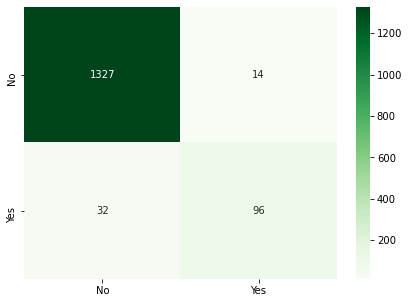

In [120]:
from sklearn.metrics import confusion_matrix
y_pred=xgb.predict(xtestsc)
print(xgb.score(xtestsc,y_test))
cm=confusion_matrix(y_test,y_pred,labels=[0,1])
df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g',cmap="Greens")

Best Threshold=0.125024, G-Mean=0.921


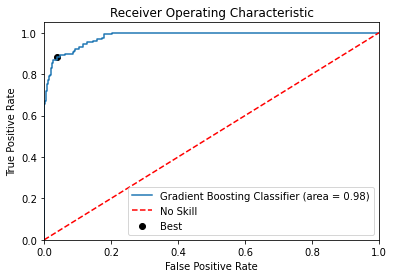

In [121]:
xgb_roc_auc = roc_auc_score(y_test, xgb.predict_proba(xtestsc)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(xtestsc)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gradient Boosting Classifier (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'r--',label='No Skill')
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('XGB_ROC')
plt.show()

## Support Vector Machine Classifier

In [122]:
from sklearn.svm import SVC

# Building a Support Vector Machine on train data
svc_model = SVC(C= .1, kernel='linear', gamma= 1)
svc_model.fit(xtrainsc, y_train)

prediction = svc_model .predict(xtestsc)


In [123]:
# check the accuracy on the training set
print(f"Train Accuracy: {svc_model.score(xtrainsc, y_train)}")
print(f"Test Accuracy {svc_model.score(xtestsc, y_test)}")

Train Accuracy: 0.9562171628721541
Test Accuracy 0.9489448604492853


0.9489448604492853


<AxesSubplot:>

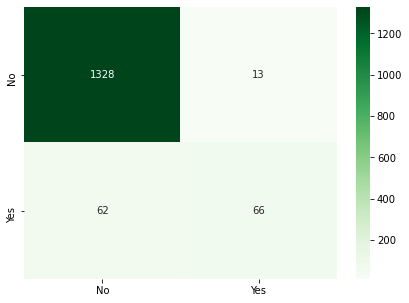

In [124]:
from sklearn.metrics import confusion_matrix
y_pred=svc_model.predict(xtestsc)
print(svc_model.score(xtestsc,y_test))
cm=confusion_matrix(y_test,y_pred,labels=[0,1])
df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g',cmap="Greens")

In [125]:
SVC_test_model_pred=svc_model.predict(xtestsc)
print("Classification Report")
print(metrics.classification_report(y_test, SVC_test_model_pred, labels=[1, 0]))

Classification Report
              precision    recall  f1-score   support

           1       0.84      0.52      0.64       128
           0       0.96      0.99      0.97      1341

    accuracy                           0.95      1469
   macro avg       0.90      0.75      0.81      1469
weighted avg       0.94      0.95      0.94      1469



# COMPARISON OF THE MODELS

LR: 0.947630 (0.014805)
NB: 0.908757 (0.017458)
KNN: 0.955990 (0.012974)
CART: 0.964543 (0.007523)
RF: 0.975703 (0.010951)
Bagging: 0.973635 (0.009902)
ADABoost: 0.963840 (0.010079)
GradientBoost: 0.972501 (0.009422)
XGB: 0.972743 (0.012255)
SVM: 0.967034 (0.015340)


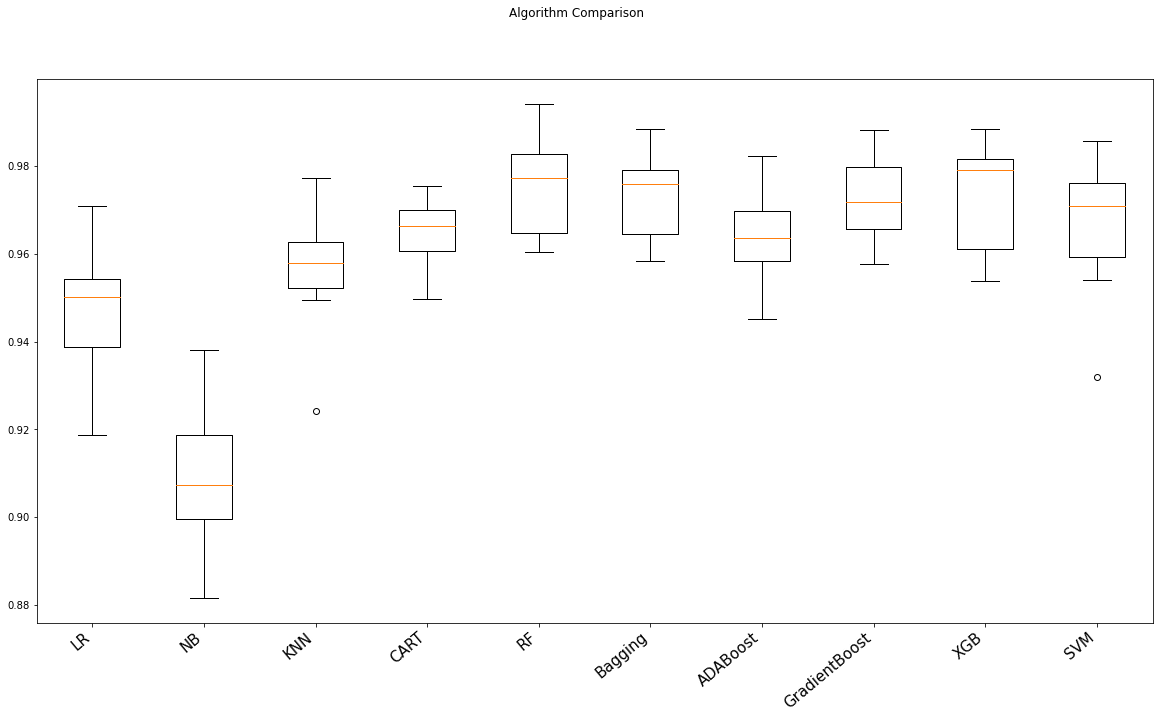

In [126]:
from sklearn import model_selection
models = []
models.append(('LR', LogisticRegression()))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('Bagging',BaggingClassifier()))
models.append(('ADABoost', AdaBoostClassifier()))
models.append(('GradientBoost',GradientBoostingClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []
seed=7
scoring = 'precision_weighted'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=7,shuffle=True)
	cv_results = model_selection.cross_val_score(model, xtrainsc, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison

fig = plt.figure(figsize=(20,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names,rotation=40,ha='right',fontsize=15)
plt.show()

In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
:param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
dfs = []
models = [
          ('LogReg', LogisticRegression()),
          ('GNB', GaussianNB()),
          ('KNN', KNeighborsClassifier()),
          ('CART',DecisionTreeClassifier()),
          ('RF', RandomForestClassifier()),
          ('Bagging',BaggingClassifier()),
          ('ADABoost', AdaBoostClassifier()),
          ('GradientBoost',GradientBoostingClassifier()),
          ('SVM', SVC()), 
          ('XGB', XGBClassifier())
 
        ]
results = []
names = []
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
target_names = ['Yes', 'No']
for name, model in models:
        kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=7)
        cv_results = model_selection.cross_validate(model, xtrainsc, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(xtrainsc, y_train)
        y_pred = clf.predict(xtestsc)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)

LogReg
              precision    recall  f1-score   support

         Yes       0.96      0.99      0.97      1341
          No       0.81      0.55      0.65       128

    accuracy                           0.95      1469
   macro avg       0.89      0.77      0.81      1469
weighted avg       0.95      0.95      0.95      1469

GNB
              precision    recall  f1-score   support

         Yes       0.96      0.92      0.94      1341
          No       0.41      0.59      0.49       128

    accuracy                           0.89      1469
   macro avg       0.69      0.75      0.71      1469
weighted avg       0.91      0.89      0.90      1469

KNN
              precision    recall  f1-score   support

         Yes       0.96      1.00      0.98      1341
          No       0.95      0.62      0.75       128

    accuracy                           0.96      1469
   macro avg       0.96      0.81      0.86      1469
weighted avg       0.96      0.96      0.96      1469

CART

# Conclusion

In this dataset, the classification goal is to predict if a customer with liabilities with the bank (mortgage, credit card expenses) will avail(1 / 0) a personal loan.

It is obvious that the data for personal loan is quite imbalanced. 90.4% of the data comprises customers without personal loans (0). 9.6% of the customers opted for a personal loan (1). After removing outliers, the ratio is even more skewed. 

Most of the standard metrics assume a balanced class distribution. A high accuracy (or low error) is achievable by a no skill model that only predicts the majority class in an imbalanced distribution. 

Classification accuracy is therefore inappropriate for this data set.  Hence, the comparison of sensitivity (TPR / Recall), F Score and Precision will also be considered for each model.


For the Logistic Regression model, Precision is 96%, Recall is 99%, G Mean (balance of sensitivity and specificity) is 0.897 and F Score (balance of Precision and Recall) is 0.97. AUC-ROC is 95%.

For the Naive Bayes model, Precision is 96%, Recall is 92%, G Mean (balance of sensitivity and specificity) is 0.877 and F Score (balance of Precision and Recall) is 0.94. AUC-ROC is 92%.

For the kNN model, Precision is 96%, Recall is 100%, G Mean (balance of sensitivity and specificity) is 0.895 and F Score (balance of Precision and Recall) is 0.98. AUC-ROC is 97%.

For the Decision Tree model, Precision is 98%, Recall is 97%, G Mean (balance of sensitivity and specificity) is 0.962 and F Score (balance of Precision and Recall) is 0.97. AUC-ROC is 98%.

For the Random Forests model, Precision is 98%, Recall is 99%, G Mean (balance of sensitivity and specificity) is 0.931 and F Score (balance of Precision and Recall) is 0.98. AUC-ROC is 97%.

For the BaggingClassifier model, Precision is 97%, Recall is 99%,G Mean (balance of sensitivity and specificity) is 0.89 and  F Score (balance of Precision and Recall) is 0.98. AUC-ROC is 94%.

For the AdaBoosting model, Precision is 97%, Recall is 98%, G Mean (balance of sensitivity and specificity) is 0.945 and F Score (balance of Precision and Recall) is 0.98. AUC-ROC is 99%.

For the GradientBoosting model, Precision is 98%, Recall is 99%, G Mean (balance of sensitivity and specificity) is 0.968 and F Score (balance of Precision and Recall) is 0.98. AUC-ROC is 97%.

For the XGBoost model, Precision is 98%, Recall is 99%, G Mean (balance of sensitivity and specificity) is 0.921 and F Score (balance of Precision and Recall) is 0.98. AUC-ROC is 98%.

<b>From the comparison given above, for this dataset, XGBoost model scores the best. With a highest precison, comparable recall value, Good Macro F Score and greater AUC in both ROC and precision-recall curves, it scores above all the other models.</b>

# Calculation of Custom Credit Score

Since the XGB model performed the best, we will be using the weights of xgb model to calculate the credit score

<AxesSubplot:>

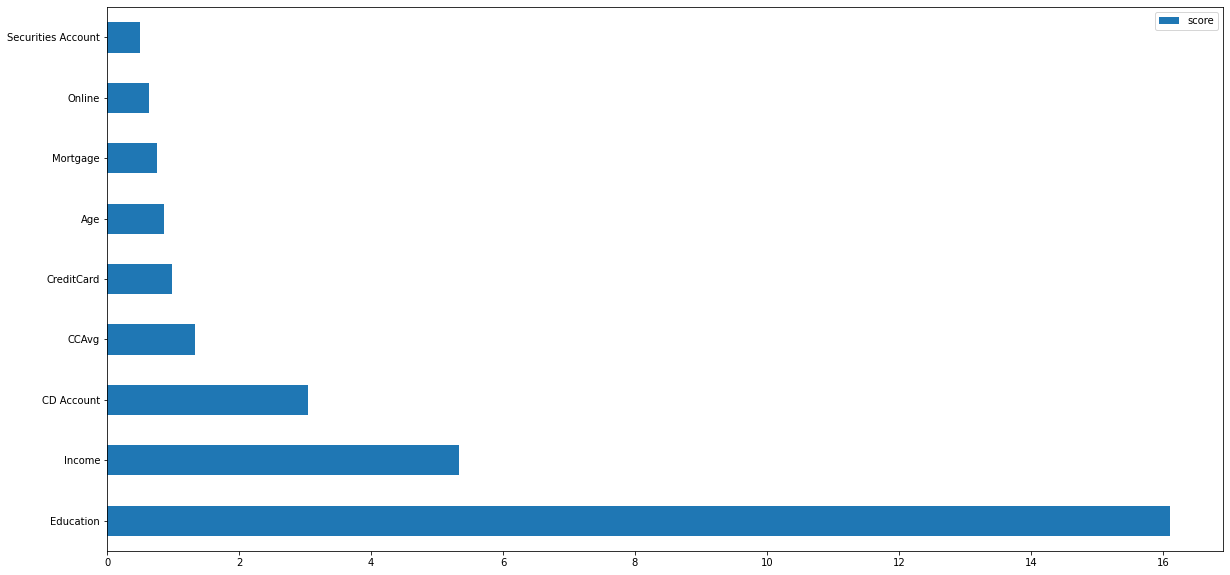

In [128]:
feature_important = xgb.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [129]:
feature_important

{'Income': 5.325990692742593,
 'CCAvg': 1.334961828405729,
 'CD Account': 3.0493442579272716,
 'Age': 0.8697383303902683,
 'Education': 16.107817862519525,
 'Mortgage': 0.7550093998221049,
 'Online': 0.6377925172806451,
 'CreditCard': 0.9855064680400001,
 'Securities Account': 0.49767421011111107}

We see that the most important columns in the dataset that contribute to the prediction are the Education, Income, CD Account and CCAvg. Thus we will be using these to calculate our credit score for each record

In [130]:
Db2=Db1.apply(zscore)

In [131]:
Db['Credit Score']=(Db2['Education']*feature_important['Education'])+(Db2['Income']*feature_important['Income'])+(Db2['CD Account']*feature_important['CD Account'])+(Db2['CCAvg']*feature_important['CCAvg'])

In [132]:
Db.head()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,Credit Score
ID,,,,,,,,,,,,,,
1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0,-20.758941
2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0,-22.623777
3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0,-25.753971
4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0,5.364819
5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1,-2.514371


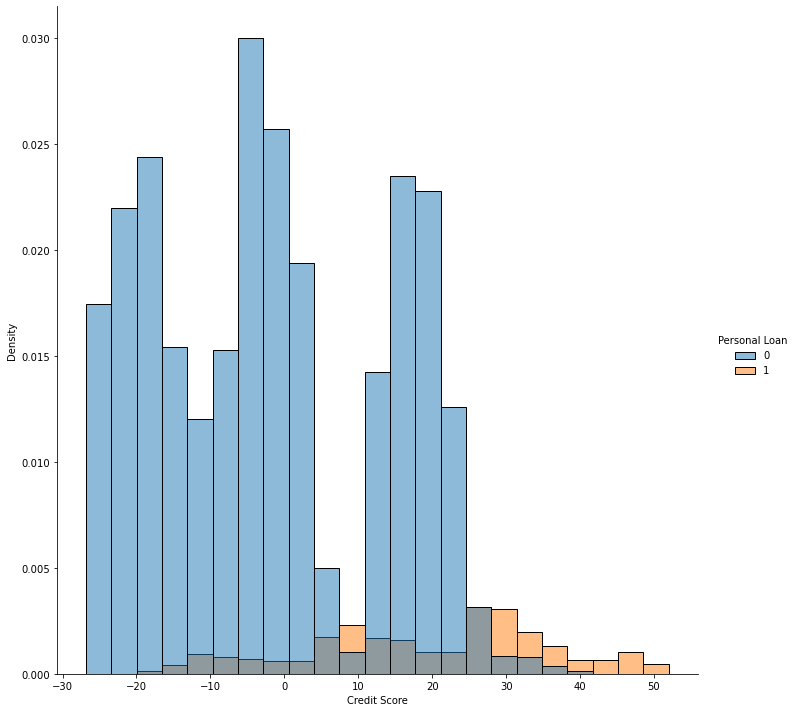

In [133]:
sns.displot(Db, x="Credit Score", hue="Personal Loan", stat='density',height=10)

<b>Thus, We can conclude that people with a higher credit score are more likely to get a loan when compared to people with a low Credit Score. We can further work to get a better formula to calculate Credit Score which is more accurate.</b>